<a href="https://colab.research.google.com/github/YuxingW/machine_learning/blob/main/hw1_cluster_kmean/tensorflow_kmean.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# What is the story is telling us
For a PXE server (an ISO installation system) in a software enterprise company, it is often hard to automatically recognize the porformance issue in the system. <br />
This notebook is to use tensorflow KMean algorithm to identify the porformance issue based on the cluster patterns. <br />

###The data set is statistic of number of clients to complete the ISO installation based on the installation time (hours) they take, features <br />
1h - Number of clients which ISO installation time are within 1h <br />
2h - Number of clients which ISO installation time are from 1h to 2h <br />
3h - Number of clients which ISO installation time are from 2h to 3h <br />

###We think the system performance is good if most clients can complete the ISO installation within 2h.

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import requests
import pandas as pd
from io import BytesIO

train_url = 'https://docs.google.com/spreadsheets/d/e/2PACX-1vQ6Mh5ImYPClwVFxwEy9HfV-h0syzcjozBkqq-dq5Mc2Wnrgk5KD7m38sQDa81elTMoqqR82CfRz3vm/pub?output=csv'
r = requests.get(train_url)
data = r.content
df = pd.read_csv(BytesIO(data))
df.head()

,1h,2h,3h,label
0,58,140,25,0
1,49,144,33,0
2,60,144,26,0
3,60,124,35,0
4,58,132,31,0


Normalize data

In [2]:
from sklearn import preprocessing

x = df.drop(['label'], axis=1).to_numpy() #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
normalized_df = pd.DataFrame(x_scaled)

Use elbow method to determine cluster numbers N

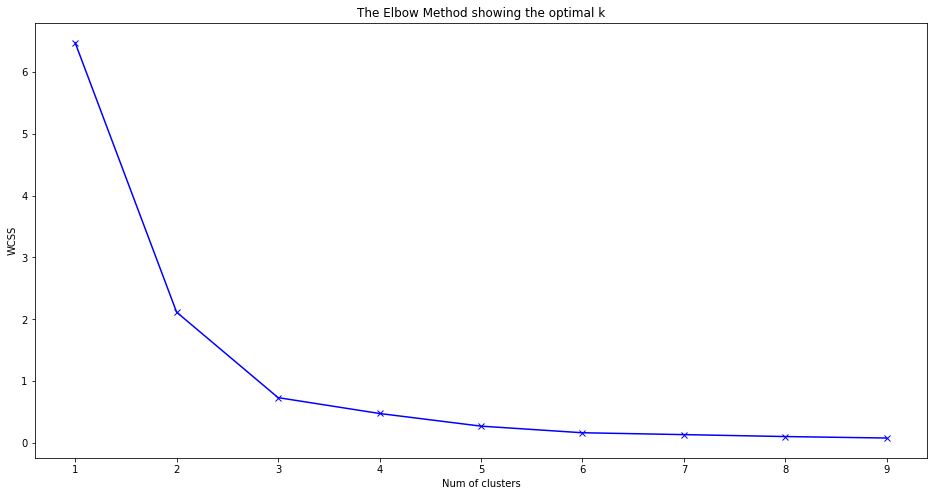

In [3]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

wcss = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k, init='k-means++', random_state=42)
    kmeanModel.fit(x_scaled)
    wcss.append(kmeanModel.inertia_)

plt.figure(figsize=(16,8))
plt.plot(K, wcss, 'bx-')
plt.xlabel('Num of clusters')
plt.ylabel('WCSS')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [4]:
num_points = 33
dimensions = 3
num_clusters = 3
#points = np.random.uniform(0, 1000, [num_points, dimensions])
points = df.drop(['label'], axis=1).values #returns a numpy array

def input_fn():
  return tf.compat.v1.train.limit_epochs(
      tf.convert_to_tensor(points, dtype=tf.float32), num_epochs=1)

kmeans = tf.compat.v1.estimator.experimental.KMeans(
    num_clusters=num_clusters, use_mini_batch=False)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmp78kqi9up', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_checkpoint_save_graph_def': True, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


## Train

In [5]:
num_iterations = 10
previous_centers = None
for _ in range(num_iterations):
  kmeans.train(input_fn)
  cluster_centers = kmeans.cluster_centers()
  if previous_centers is not None:
    print('delta:', cluster_centers - previous_centers)
  previous_centers = cluster_centers
  print('score:', kmeans.score(input_fn))
print('cluster centers:', cluster_centers)

Instructions for updating:
Use Variable.read_value. Variables in 2.X are initialized automatically both in eager and graph (inside tf.defun) contexts.
Instructions for updating:
Queue-based input pipelines have been replaced by `tf.data`. Use `tf.data.Dataset.from_tensors(tensor).repeat(num_epochs)`.
Instructions for updating:
Prefer Dataset.range instead.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 0...
INFO:tensorflow:Saving checkpoints for 0 into /tmp/tmp78kqi9up/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 0...
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 1...
INFO:tensorflow:Saving checkpoints for 1 into /tmp/tmp78kqi9up/model.ckpt.
INFO:tensorflow:Calling checkp

## Map the input points to their clusters

In [6]:
cluster_indices = list(kmeans.predict_cluster_index(input_fn))
print(cluster_indices)
for i, point in enumerate(points):
  cluster_index = cluster_indices[i]
  center = cluster_centers[cluster_index]
  print('point:', point, 'is in cluster', cluster_index, 'centered at', center)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmp78kqi9up/model.ckpt-19
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
[0, 0, 0, 0, 0, 1, 1, 2, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 2, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
point: [ 58 140  25] is in cluster 0 centered at [ 55.142853 139.14284   30.190474]
point: [ 49 144  33] is in cluster 0 centered at [ 55.142853 139.14284   30.190474]
point: [ 60 144  26] is in cluster 0 centered at [ 55.142853 139.14284   30.190474]
point: [ 60 124  35] is in cluster 0 centered at [ 55.142853 139.14284   30.190474]
point: [ 58 132  31] is in cluster 0 centered at [ 55.142853 139.14284   30.190474]
point: [ 23 163  43] is in cluster 1 centered at [ 11.299999 167.79999   47.899994]
point: [ 18 175  37] is in cluster 1 centered at [ 11.299999 167.79999   47.899994]
point: [  7  98 124] is in cluster 2 centered 

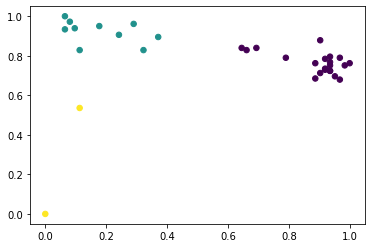

In [8]:
X = normalized_df[0:].values
plt.scatter(X[:, 0], X[:, 1], c=cluster_indices, s=30, cmap='viridis')
plt.show()

###What the clustering results represent: <br />
cluster 0: Most clients complete their ISO Installation in 1h - 2h, then less in 0h - 1h, least in 2h - 3h <br />
cluster 1: Most clients complete their ISO Installation in 1h - 2h, then less in 2h - 3h, least in 0h - 1h <br />
cluster 2: Most clients complete their ISO Installation in 2h - 3h, then less in 1h - 2h, least in 0h - 1h <br />


Therefore, <br />
if the latest data falls to cluster 0, it indicates that the performance of the system is doing well, that is called ideal scenario. <br />
if the latest data falls to cluster 1, it indicates that the performance of the system is getting worse, maintainers need to pay attention. <br />
if the latest data falls to cluster 2, it indicates that the performance of the system needs to improve immediately, that is the worst scenario. <br />



Refference:
https://www.tensorflow.org/api_docs/python/tf/compat/v1/estimator/experimental/KMeans